In [1]:
import argparse
import json
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import sknw
import torch
import torch.nn.functional as F
from natsort import natsorted
from skimage.morphology import medial_axis, remove_small_objects
from torch_geometric.data import DataLoader, Data, Batch
from torch_geometric.datasets import TUDataset
from tqdm.notebook import tqdm

from models import Model

In [2]:
def png_to_sknw(png_path: str) -> tuple[nx.Graph, np.ndarray]:
    """
    Convert a PNG image to a skeletonized graph.

    Args:
        png_path (str): The path to the PNG image.

    Returns:
        tuple[nx.Graph, np.ndarray]: A tuple containing the skeletonized graph and the cleaned skeleton image.
    """
    img = cv2.imread(png_path, 0)
    _, map_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    skel, _ = medial_axis(map_thresh, return_distance=True)
    skel_clean = remove_small_objects(skel, connectivity=10, min_size=10)

    skel_graph = sknw.build_sknw(skel_clean)

    return skel_graph, skel_clean

In [3]:
def visualize(png_path, sparsify_deg=None):
    skel_graph, skel_clean = png_to_sknw(png_path)

    if sparsify_deg:
        # Remove nodes with less than 3 edges
        nodes_to_remove = [
            node for node, degree in skel_graph.degree() if degree < sparsify_deg
        ]
        skel_graph.remove_nodes_from(nodes_to_remove)

    img = cv2.imread(png_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(20, 20))
    plt.subplot(121)
    plt.imshow(img)
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(skel_clean, cmap="gray")
    # draw edges by pts
    for s, e in skel_graph.edges():
        ps = skel_graph[s][e]["pts"]
        plt.plot(ps[:, 1], ps[:, 0], "green")
    # draw node by o
    nodes = skel_graph.nodes()
    ps = np.array([nodes[i]["o"] for i in nodes])
    plt.plot(ps[:, 1], ps[:, 0], "r.")
    plt.title("Skeletonized Graph")
    plt.show()

In [4]:
args = argparse.Namespace()

args.seed = 777
args.batch_size = 512
args.lr = 0.001
args.weight_decay = 0.001
args.nhid = 128
args.sample_neighbor = True
args.sparse_attention = True
args.structure_learning = True
args.pooling_ratio = 0.5
args.dropout_ratio = 0.0
args.lamb = 1.0
args.device = "cuda:0"
args.epochs = 1000
args.patience = 100
args.dataset = "BREAST"

torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)

dataset = TUDataset(
    os.path.join("test", args.dataset), name=args.dataset, use_node_attr=True
)

args.num_classes = dataset.num_classes
args.num_features = dataset.num_features

del dataset

In [5]:
graph_labels = pd.read_csv("test/BREAST/BREAST/raw/BREAST_graph_labels.txt")

In [6]:
graph_labels

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [7]:
tuples = pd.read_csv("test/id_path_label.csv")

In [8]:
tuples

,graph_id,png_path,path_label,graph_label
0,0,RP090_left_after_DL.png,benign,0
1,1,RP091_left_after_DL.png,benign,0
2,2,RP092_left_after_DL.png,benign,0
3,3,RP093_left_after_DL.png,benign,0
4,4,RP094_left_after_DL.png,benign,0
5,5,RP095_right_after_DL.png,benign,0
6,6,RP096_left_after_DL.png,benign,0
7,7,RP097_right_after_DL.png,benign,0
8,8,RP098_right_after_DL.png,benign,0
9,9,RP099_right_after_DL.png,benign,0


In [9]:
json_file = "test/BREAST/BREAST/raw/graph_id_map.json"
with open(json_file, "r") as f:
    test_graph_id_map = json.load(f)

In [10]:
test_pngs = natsorted(glob("test/pngs/*.png"))

In [11]:
test_graph_id_map

{'RP090_left_after_DL.png': 0,
 'RP091_left_after_DL.png': 1,
 'RP092_left_after_DL.png': 2,
 'RP093_left_after_DL.png': 3,
 'RP094_left_after_DL.png': 4,
 'RP095_right_after_DL.png': 5,
 'RP096_left_after_DL.png': 6,
 'RP097_right_after_DL.png': 7,
 'RP098_right_after_DL.png': 8,
 'RP099_right_after_DL.png': 9,
 'RP100_left_after_DL.png': 10,
 'RP101_left_after_DL.png': 11,
 'RP103_left_after_DL.png': 12,
 'RP105_left_after_DL.png': 13,
 'RP106_left_after_DL.png': 14,
 'RP107_left_after_DL.png': 15,
 'RP108_right_after_DL.png': 16,
 'RP109_left_after_DL.png': 17,
 'RP110_left_after_DL.png': 18,
 'RP111_left_after_DL.png': 19,
 'RP112_left_after_DL.png': 20,
 'RP113_left_after_DL.png': 21,
 'RP114_left_after_DL.png': 22,
 'RP115_Left_after_DL.png': 23,
 'RP116_left_after_DL.png': 24,
 'RP117_Left_after_DL.png': 25,
 'RP119_left_after_DL.png': 26,
 'RP120_left_after_DL.png': 27,
 'RP090_right_after_DL.png': 28,
 'RP091_right_after_DL.png': 29,
 'RP092_right_after_DL.png': 30,
 'RP093_ri

In [12]:
sample_index = 0
gt_graph_id = test_graph_id_map[test_pngs[sample_index].split("/")[-1]]

In [13]:
test_pngs[sample_index]

'test/pngs/RP090_left_after_DL.png'

In [14]:
tuples[tuples["png_path"] == test_pngs[sample_index].split("/")[-1]]

,graph_id,png_path,path_label,graph_label
0,0,RP090_left_after_DL.png,benign,0


In [15]:
test_pngs[1].split("/")[-1]

'RP090_right_after_DL.png'

In [16]:
edge_count = 0
node_count = 0

test_edges = []
test_graph_ids = []
test_graph_labels = []
test_node_labels = []

if os.path.exists("data/test/BREAST/BREAST/processed/"):
    os.system("rm -r data/test/BREAST/BREAST/processed/")


for graph_id, png_path in tqdm(enumerate(test_pngs[:2])):

    graph_label = graph_labels.loc[test_graph_id_map[png_path.split("/")[-1]]].values[0]

    test_graph_labels.append(graph_label)

    img = cv2.imread(png_path, 0)
    _, map_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    skel, distance = medial_axis(map_thresh, return_distance=True)
    skel_clean = remove_small_objects(skel, connectivity=10, min_size=10)

    skel_graph = sknw.build_sknw(skel_clean)

    # Remove nodes with less than 3 edges
    nodes_to_remove = [node for node, degree in skel_graph.degree() if degree < 2]
    skel_graph.remove_nodes_from(nodes_to_remove)

    skel_graph = nx.convert_node_labels_to_integers(skel_graph, first_label=node_count)

    # DS_A
    graph_edges = skel_graph.edges()
    graph_edges = np.array(graph_edges)

    graph_edge_s = graph_edges.T[0].copy()
    graph_edge_e = graph_edges.T[1].copy()
    graph_edges_rev = np.array([graph_edge_e, graph_edge_s]).T

    graph_edges = np.concatenate([graph_edges, graph_edges_rev], axis=0)

    test_edges.append(graph_edges)

    graph_id_arr = np.repeat(graph_id, len(skel_graph.nodes()))
    test_graph_ids.append(graph_id_arr)

    node_label_arr = np.repeat(graph_label, len(skel_graph.nodes()))
    test_node_labels.append(node_label_arr)

    edge_count += len(skel_graph.edges())
    node_count += len(skel_graph.nodes())

if not os.path.exists(f"data/test/BREAST/BREAST/raw"):
    os.makedirs(f"data/test/BREAST/BREAST/raw")

test_edges = np.concatenate(test_edges, axis=0)
test_edges = pd.DataFrame(test_edges, columns=["source", "target"]) + 1
test_edges.to_csv(
    f"data/test/BREAST/BREAST/raw/BREAST_A.txt", index=False, header=False
)

test_graph_ids = np.concatenate(test_graph_ids, axis=0)
test_graph_ids = pd.DataFrame(test_graph_ids, columns=["graph_id"]) + 1
test_graph_ids.to_csv(
    f"data/test/BREAST/BREAST/raw/BREAST_graph_indicator.txt", index=False, header=False
)

test_graph_labels = pd.DataFrame(test_graph_labels, columns=["graph_label"])
test_graph_labels.to_csv(
    f"data/test/BREAST/BREAST/raw/BREAST_graph_labels.txt", index=False, header=False
)

test_node_labels = np.concatenate(test_node_labels, axis=0)
test_node_labels = pd.DataFrame(test_node_labels, columns=["node_label"])
test_node_labels.to_csv(
    f"data/test/BREAST/BREAST/raw/BREAST_node_labels.txt", index=False, header=False
)

0it [00:00, ?it/s]

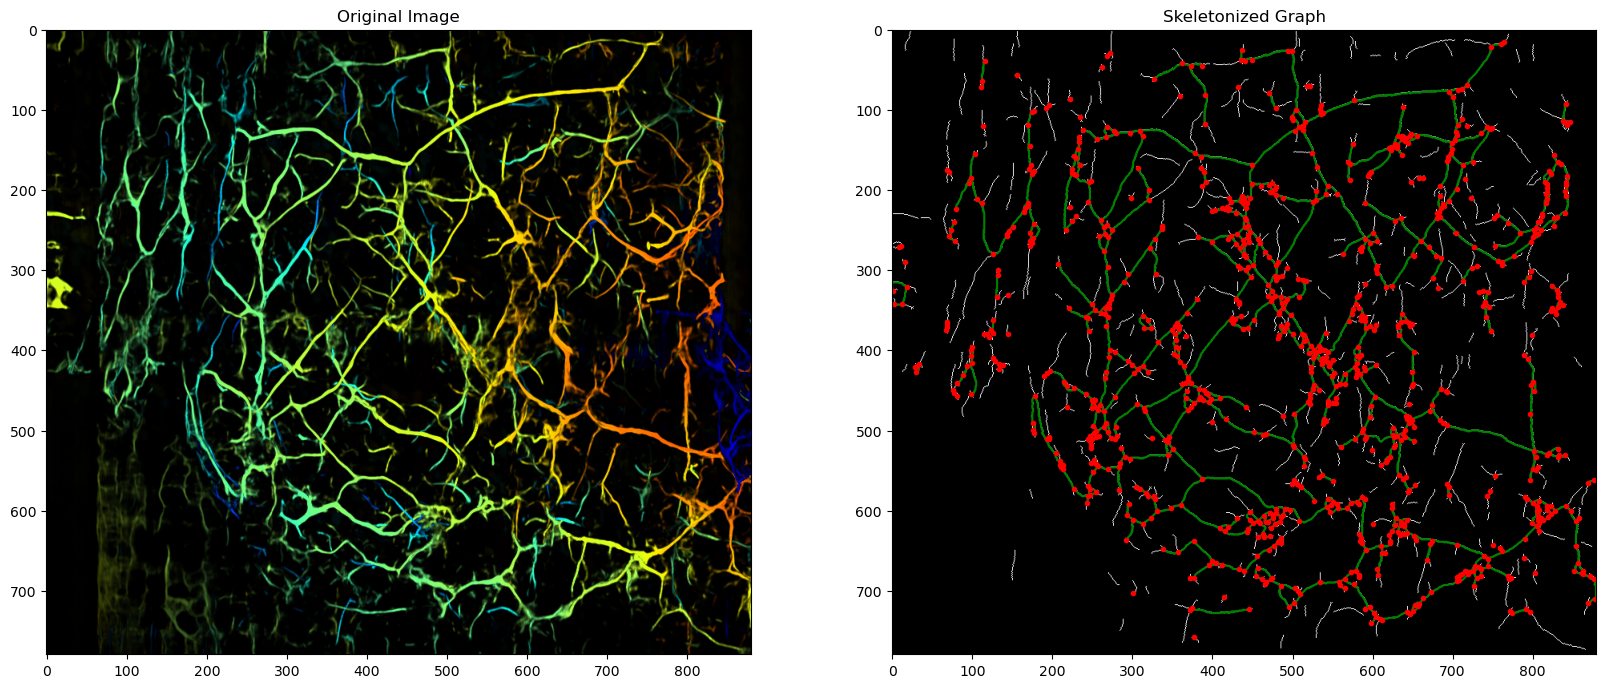

In [17]:
visualize(test_pngs[10], 2)

In [18]:
png_file = test_pngs[10].split("/")[-1]
png_file, test_graph_id_map[png_file], graph_labels.loc[
    test_graph_id_map[png_file]
].values[0]

('RP095_left_after_DL.png', 33, 1)

In [19]:
tuples[tuples["png_path"] == png_file]

,graph_id,png_path,path_label,graph_label
33,33,RP095_left_after_DL.png,malignant,1


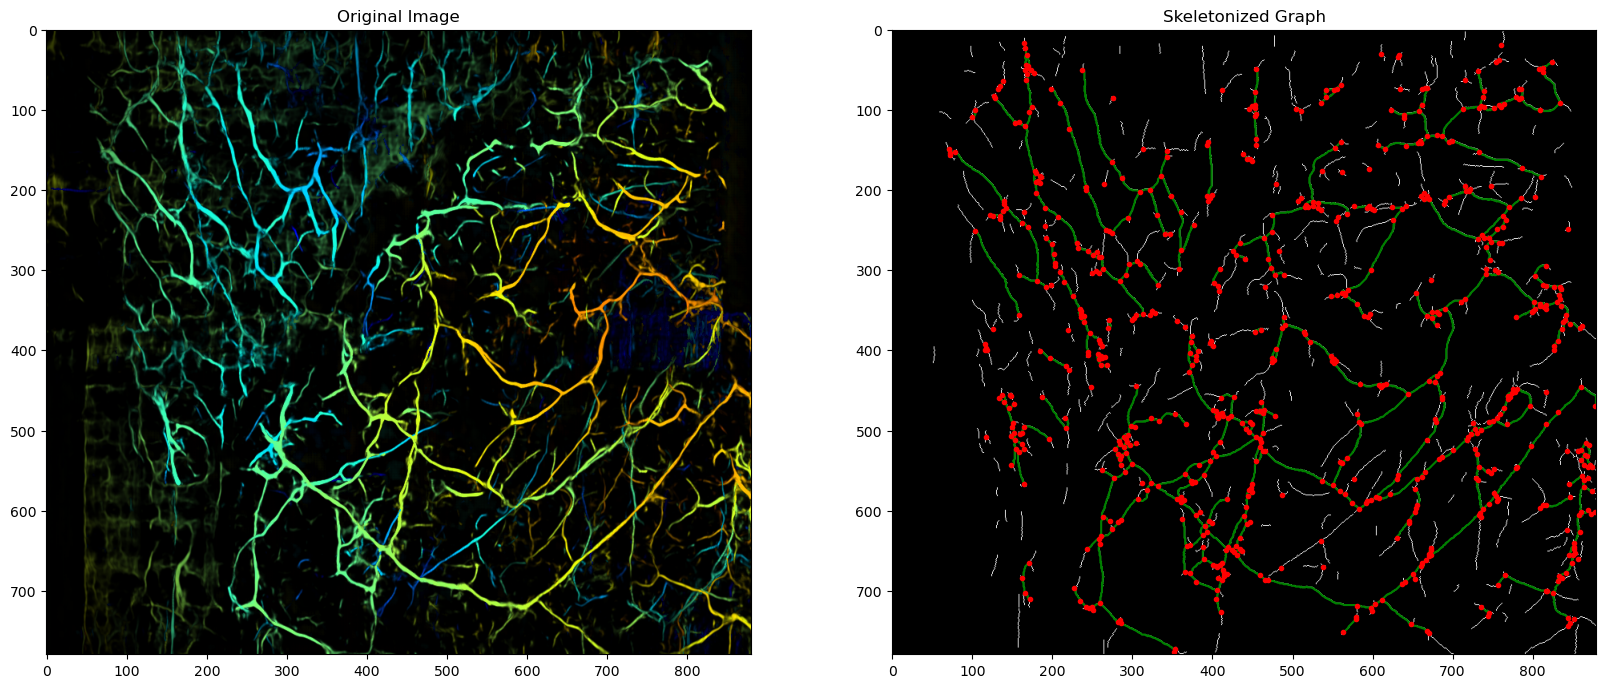

In [20]:
visualize(test_pngs[11], 2)

In [21]:
png_file = test_pngs[11].split("/")[-1]
png_file, test_graph_id_map[png_file], graph_labels.loc[
    test_graph_id_map[png_file]
].values[0]

('RP095_right_after_DL.png', 5, 0)

In [22]:
tuples[tuples["png_path"] == png_file]

,graph_id,png_path,path_label,graph_label
5,5,RP095_right_after_DL.png,benign,0


In [23]:
model = Model(args)

In [24]:
weights = natsorted(glob("*.pth"))

In [25]:
model.load_state_dict(torch.load(weights[-1]))
model.to(args.device)

Model(
  (conv1): GCNConv(2, 128)
  (conv2): GCN(128, 128)
  (conv3): GCN(128, 128)
  (pool1): HGPSLPool(
    (sparse_attention): Sparsemax()
    (calc_information_score): NodeInformationScore()
  )
  (pool2): HGPSLPool(
    (sparse_attention): Sparsemax()
    (calc_information_score): NodeInformationScore()
  )
  (lin1): Linear(in_features=256, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=2, bias=True)
)

In [26]:
dataset = TUDataset(
    os.path.join("data/test", args.dataset), name=args.dataset, use_node_attr=True
)


args.num_classes = dataset.num_classes
args.num_features = dataset.num_features

Processing...
Done!


In [27]:
test_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

/home/photoacoustic/miniconda3/envs/hgp/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [28]:
len(dataset)

2

In [29]:
with torch.no_grad():
    preds = []
    gts = []
    model.eval()
    correct = 0.0
    loss_test = 0.0
    for data in test_loader:
        data = data.to(args.device)
        out = model(data)
        pred = out.max(dim=1)[1]
        preds.append(pred.cpu().numpy())
        gts.append(data.y.cpu().numpy())
        correct += pred.eq(data.y).sum().item()
        loss_test += F.nll_loss(out, data.y).item()
        break

In [30]:
preds = np.concatenate(preds, axis=0)
gts = np.concatenate(gts, axis=0)

preds == gts

array([ True,  True])

In [31]:
gts

array([0, 1])

In [32]:
preds

array([0, 1])

In [33]:
correct / len(test_loader.dataset), f"{loss_test:.06f}"

(1.0, '0.000000')

In [34]:
data.to_data_list()

[Data(edge_index=[2, 1206], x=[575, 2], y=[1]),
 Data(edge_index=[2, 1272], x=[611, 2], y=[1])]

In [35]:
pred

tensor([0, 1], device='cuda:0')

In [36]:
dataset.get_summary()

TUDataset (#graphs=2):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |    593   |   1239   |
| std        |     25.5 |     46.7 |
| min        |    575   |   1206   |
| quantile25 |    584   |   1222.5 |
| median     |    575   |   1206   |
| quantile75 |    602   |   1255.5 |
| max        |    611   |   1272   |
+------------+----------+----------+

In [37]:
processed = torch.load("data/test/BREAST/BREAST/processed/data.pt")

In [38]:
processed

(Data(x=[1186, 2], edge_index=[2, 2478], y=[2]),
 {'edge_index': tensor([   0, 1206, 2478]),
  'x': tensor([   0,  575, 1186]),
  'y': tensor([0, 1, 2])},
 {'num_node_attributes': 0,
  'num_node_labels': 2,
  'num_edge_attributes': 0,
  'num_edge_labels': 0})

In [39]:
data

DataBatch(edge_index=[2, 2478], x=[1186, 2], y=[2], batch=[1186], ptr=[3])

In [40]:
png_file_ = test_pngs[2].split("/")[-1]

In [41]:
skel_graph_, skel_clean_ = png_to_sknw(test_pngs[2])

nodes_to_remove = [node for node, degree in skel_graph_.degree() if degree < 2]
skel_graph_.remove_nodes_from(nodes_to_remove)

skel_graph_ = nx.convert_node_labels_to_integers(skel_graph_, first_label=0)

In [42]:
y_ = tuples[tuples["png_path"] == png_file_]["graph_label"].values[0]

In [43]:
y_

0

In [44]:
data

DataBatch(edge_index=[2, 2478], x=[1186, 2], y=[2], batch=[1186], ptr=[3])

In [45]:
ex = data.get_example(1)
ex_dict = ex.to_dict()

In [46]:
ex_dict

{'edge_index': tensor([[  2,   3,   3,  ..., 609, 609, 610],
         [  4,   5,   7,  ..., 608, 610, 609]], device='cuda:0'),
 'x': tensor([[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]], device='cuda:0'),
 'y': tensor([1], device='cuda:0')}

In [47]:
ex_dict["edge_index"]

tensor([[  2,   3,   3,  ..., 609, 609, 610],
        [  4,   5,   7,  ..., 608, 610, 609]], device='cuda:0')

In [48]:
edge_index_ = np.array(skel_graph_.edges()).T

In [49]:
torch.tensor(edge_index_, dtype=torch.long)

tensor([[   2,    3,    4,  ...,  995,  997,  998],
        [   4,    8,   15,  ...,  997,  998, 1001]])

In [50]:
ex_dict["x"], ex_dict["x"].shape

(tensor([[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]], device='cuda:0'),
 torch.Size([611, 2]))

In [51]:
ex.num_nodes

611

In [52]:
x_ = F.one_hot(
    torch.tensor(np.repeat(y_, skel_graph_.number_of_nodes())), num_classes=2
).float()

In [53]:
ex_ = Data(
    edge_index=torch.tensor(edge_index_, dtype=torch.long),
    x=x_,
    y=torch.tensor([y_], dtype=torch.long),
)

In [54]:
data_ = Batch.from_data_list([ex_])

In [55]:
out_ = model(data_.to(args.device))
pred_ = out_.max(dim=1)[1]

In [56]:
pred_

tensor([0], device='cuda:0')

In [57]:
data_.y.cpu().numpy()

array([0])

In [63]:
def predict_png(png_path: str) -> int:
    skel_graph, skel_clean = png_to_sknw(png_path)

    nodes_to_remove = [node for node, degree in skel_graph.degree() if degree < 2]
    skel_graph.remove_nodes_from(nodes_to_remove)

    skel_graph = nx.convert_node_labels_to_integers(skel_graph, first_label=0)

    edge_index = np.array(skel_graph.edges()).T
    y = tuples[tuples["png_path"] == png_path.split("/")[-1]]["graph_label"].values[0]
    x = F.one_hot(
        torch.tensor(np.repeat(y, skel_graph.number_of_nodes())), num_classes=2
    ).float()

    ex = Data(edge_index=torch.tensor(edge_index, dtype=torch.long), x=x)
    # y=torch.tensor([y], dtype=torch.long),
    # )
    data = Batch.from_data_list([ex])

    with torch.no_grad():
        out = model(data.to(args.device))
        loss = F.nll_loss(
            out, torch.tensor(y, dtype=torch.long).unsqueeze(0).to(args.device)
        )
    pred = out.max(dim=1)[1]

    return pred.cpu().numpy()[0], y, loss.item()

In [65]:
for png_path in test_pngs:
    pred, gt, loss = predict_png(png_path)
    print(
        f"Predicted: {pred}, Ground Truth: {gt}, Match? {pred == gt}, Loss: {loss:.06f}"
    )

Predicted: 0, Ground Truth: 0, Match? True, Loss: 0.000000
Predicted: 1, Ground Truth: 1, Match? True, Loss: 0.000000
Predicted: 0, Ground Truth: 0, Match? True, Loss: 0.000000
Predicted: 1, Ground Truth: 1, Match? True, Loss: 0.000000
Predicted: 0, Ground Truth: 0, Match? True, Loss: 0.000000
Predicted: 1, Ground Truth: 1, Match? True, Loss: 0.000000
Predicted: 0, Ground Truth: 0, Match? True, Loss: 0.000000
Predicted: 1, Ground Truth: 1, Match? True, Loss: 0.000000
Predicted: 0, Ground Truth: 0, Match? True, Loss: 0.000000
Predicted: 1, Ground Truth: 1, Match? True, Loss: 0.000000
Predicted: 1, Ground Truth: 1, Match? True, Loss: 0.000000
Predicted: 0, Ground Truth: 0, Match? True, Loss: 0.000000
Predicted: 0, Ground Truth: 0, Match? True, Loss: 0.000000
Predicted: 1, Ground Truth: 1, Match? True, Loss: 0.000000
Predicted: 1, Ground Truth: 1, Match? True, Loss: 0.000000
Predicted: 0, Ground Truth: 0, Match? True, Loss: 0.000000
Predicted: 1, Ground Truth: 1, Match? True, Loss: 0.0000